In [19]:
import pandas as pd
import zipfile
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
import shap

## Reading in the data 

here is also changed the target variable to deposit_subs

In [20]:
# zip_file_path = 'Bank_Dataset/bank-additional-short.zip'
# csv_file_name = 'bank-additional-short.csv'

zip_file_path = 'Bank_Dataset/bank-additional-full.zip'
csv_file_name = 'bank-additional-full.csv'


with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    with zip_ref.open(csv_file_name) as csv_file:
        df = pd.read_csv(csv_file,sep=';')

df=df.rename(columns={'y':'deposit_subs'})

In [21]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,deposit_subs
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


## having a look at the data

In [22]:
df.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
deposit_subs       object
dtype: object

### no missing values

In [23]:
for x in df.columns:
    print(f' {x} has: {df[x].isna().sum()} missing values')

 age has: 0 missing values
 job has: 0 missing values
 marital has: 0 missing values
 education has: 0 missing values
 default has: 0 missing values
 housing has: 0 missing values
 loan has: 0 missing values
 contact has: 0 missing values
 month has: 0 missing values
 day_of_week has: 0 missing values
 duration has: 0 missing values
 campaign has: 0 missing values
 pdays has: 0 missing values
 previous has: 0 missing values
 poutcome has: 0 missing values
 emp.var.rate has: 0 missing values
 cons.price.idx has: 0 missing values
 cons.conf.idx has: 0 missing values
 euribor3m has: 0 missing values
 nr.employed has: 0 missing values
 deposit_subs has: 0 missing values


### value distribution 

In [24]:
for x in df.columns:
    print(df[x].value_counts(dropna=False))

age
31    1947
32    1846
33    1833
36    1780
35    1759
      ... 
89       2
91       2
94       1
87       1
95       1
Name: count, Length: 78, dtype: int64
job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: count, dtype: int64
marital
married     24928
single      11568
divorced     4612
unknown        80
Name: count, dtype: int64
education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: count, dtype: int64
default
no         32588
unknown     8597
yes            3
Name: count, dtype: int64
housing
yes        21576
no         18622
unknown      990
Name: count, 

In [25]:
df.pdays.value_counts()

pdays
999    39673
3        439
6        412
4        118
9         64
2         61
7         60
12        58
10        52
5         46
13        36
11        28
1         26
15        24
14        20
8         18
0         15
16        11
17         8
18         7
22         3
19         3
21         2
25         1
26         1
27         1
20         1
Name: count, dtype: int64

About droping "pdays":

Def: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

Since most of the clinets were not previously contacted and the number 999 making no sense in this context (since it was just a filler) it makes more sense to just look at a binary. But since this information is already perserved in the column "previous" i will just drop pdays.

In [26]:
df=df.drop(columns='pdays')

Also: "default", "housing" and "loan" have unknown in their feature space which can be either handeled replaced with nan values and then imputed or removed or just handled as a value on its own. I will do later one.

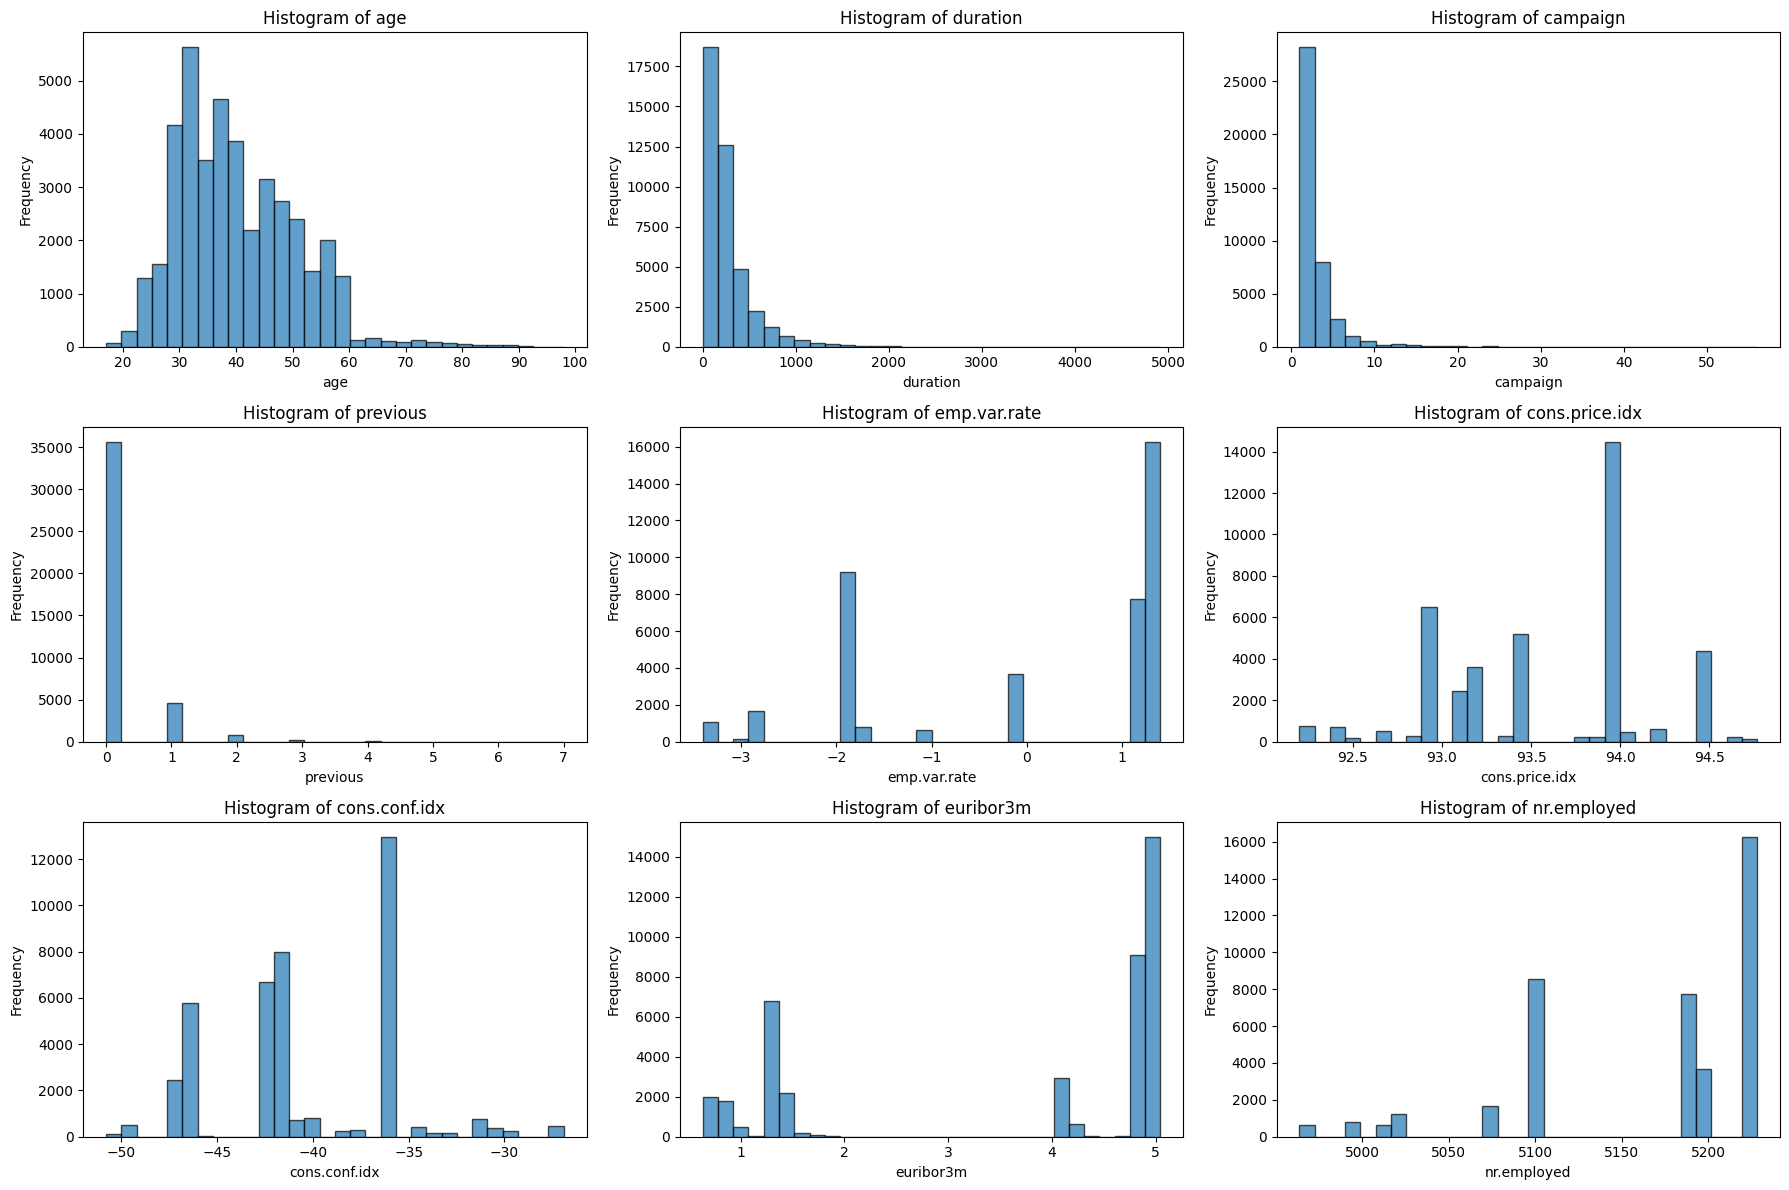

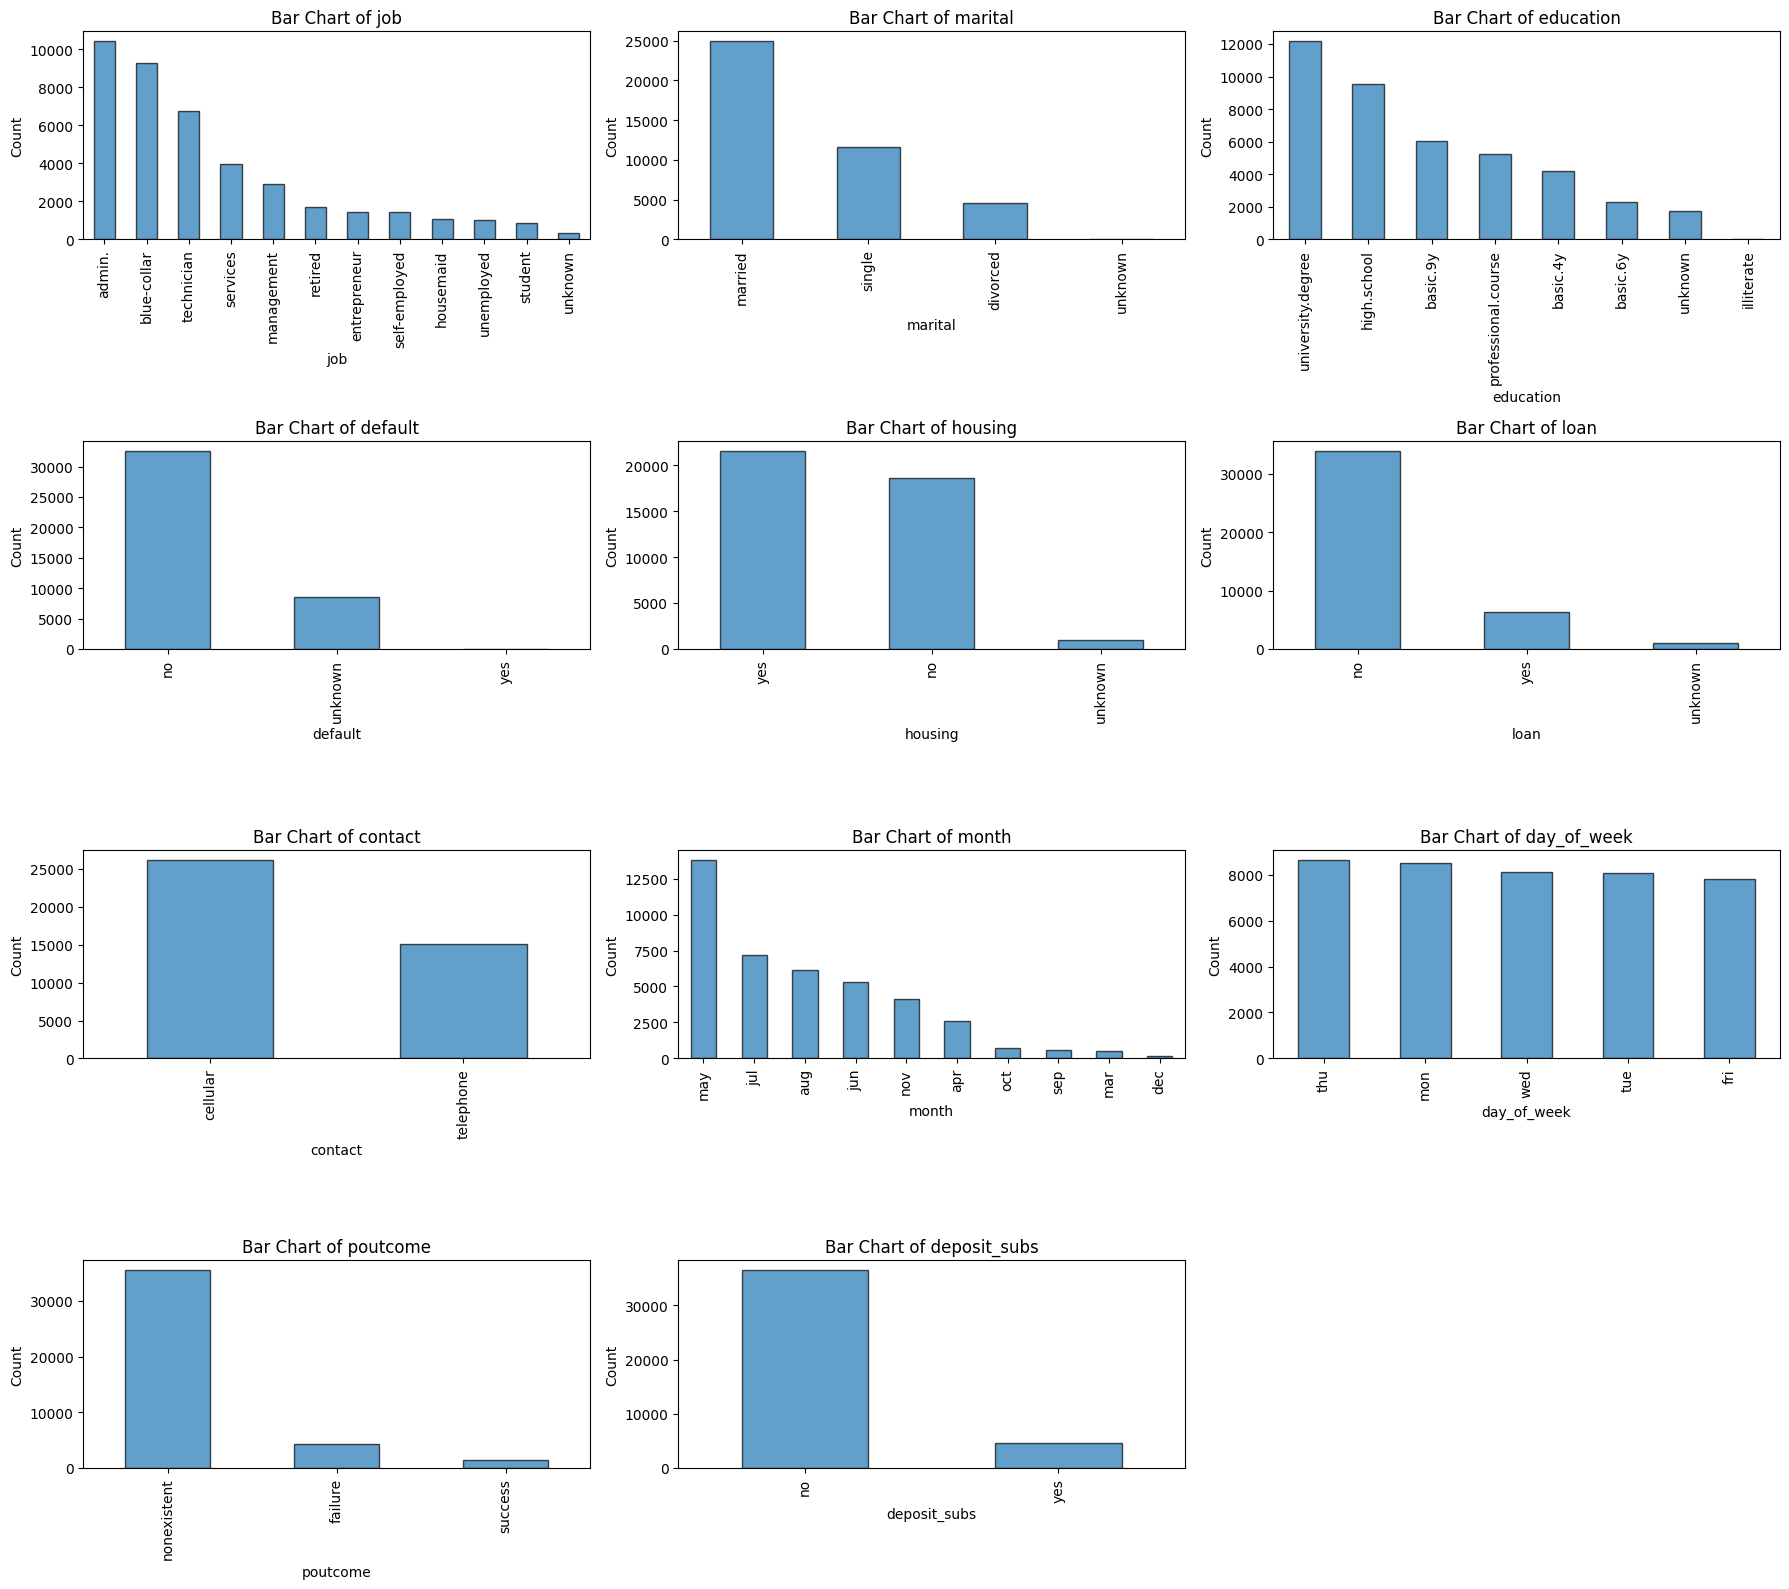

In [27]:
numeric_columns = df.select_dtypes(include=['number']).columns
categorical_columns = df.select_dtypes(include=['object', 'category']).columns

def plot_numeric_columns(df, columns):
    num_cols = len(columns)
    rows = (num_cols + 2) // 3
    fig, axes = plt.subplots(nrows=rows, ncols=3, figsize=(18, 4*rows))
    axes = axes.flatten()
    for ax, col in zip(axes, columns):
        ax.hist(df[col].dropna(), bins=30, edgecolor='k', alpha=0.7)
        ax.set_title(f'Histogram of {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Frequency')
    for i in range(num_cols, len(axes)):
        fig.delaxes(axes[i])
    plt.tight_layout()
    plt.show()

def plot_categorical_columns(df, columns):
    num_cols = len(columns)
    rows = (num_cols + 2) // 3
    fig, axes = plt.subplots(nrows=rows, ncols=3, figsize=(18, 4*rows))
    axes = axes.flatten()
    for ax, col in zip(axes, columns):
        df[col].value_counts().plot(kind='bar', ax=ax, edgecolor='k', alpha=0.7)
        ax.set_title(f'Bar Chart of {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Count')
    for i in range(num_cols, len(axes)):
        fig.delaxes(axes[i])
    plt.tight_layout()
    plt.show()

if len(numeric_columns) > 0:
    plot_numeric_columns(df, numeric_columns)
if len(categorical_columns) > 0:
    plot_categorical_columns(df, categorical_columns)

### correlations

Looking at linear dependencies to get a feel of the data. I will look at the numeric columns and als the binary ones including or target variable "

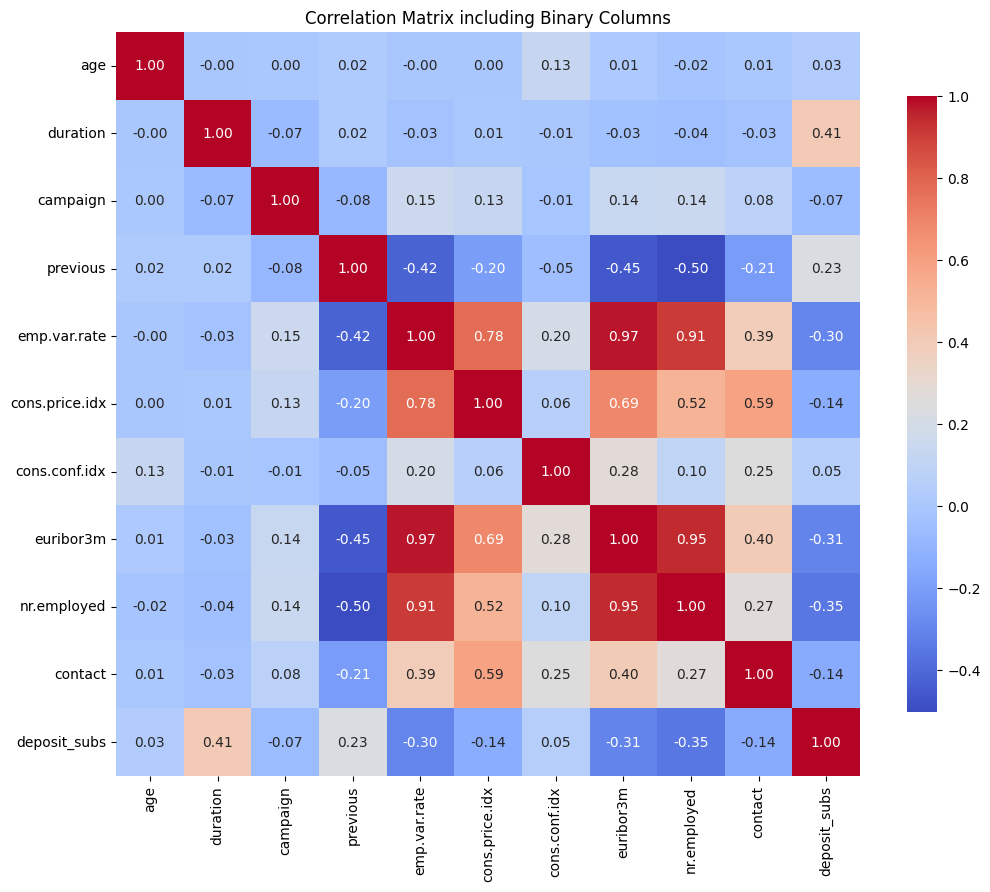

,Variable 1,Variable 2,Correlation
0,euribor3m,emp.var.rate,0.972245
1,euribor3m,nr.employed,0.945154
2,nr.employed,emp.var.rate,0.906970
3,cons.price.idx,emp.var.rate,0.775334
4,euribor3m,cons.price.idx,0.688230
5,cons.price.idx,contact,0.591474
6,nr.employed,cons.price.idx,0.522034
7,nr.employed,previous,0.501333
8,previous,euribor3m,0.454494
9,emp.var.rate,previous,0.420489


In [28]:
binary_columns = [col for col in df.columns if df[col].nunique() == 2]

binary_df = pd.DataFrame()
binary_mappings = {}
for col in binary_columns:
    df[col] = df[col].astype('category')
    binary_df[col] = df[col].astype('category').cat.codes
    binary_mappings[col] = dict(enumerate(df[col].cat.categories))
df_numeric_and_binary = pd.concat([df[numeric_columns], binary_df], axis=1)

correlation_matrix = df_numeric_and_binary.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={'shrink': .8})
plt.title('Correlation Matrix including Binary Columns')
plt.show()

correlations = correlation_matrix.unstack()

correlations = correlations[correlations < 1]

sorted_correlations = correlations.abs().sort_values(ascending=False).drop_duplicates()

top_10_correlations = sorted_correlations.head(10)

summary_table = pd.DataFrame(top_10_correlations).reset_index()
summary_table.columns = ['Variable 1', 'Variable 2', 'Correlation']
summary_table

In [29]:
print("\nBinary Mappings:")
for col, mapping in binary_mappings.items():
    print(f"{col}: {mapping}")


Binary Mappings:
contact: {0: 'cellular', 1: 'telephone'}
deposit_subs: {0: 'no', 1: 'yes'}


The "Social and economic context attributes" seem to be highly correlated. I will atleast drop one of them: "euribor3m".  

In [30]:
df=df.drop(columns='euribor3m')

## Getting ready for modeling 

Lets split the data into train and test data.

In [31]:
X = df.drop('deposit_subs', axis=1)
y = df['deposit_subs']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2, stratify=y)

Now there are object/category features we need to handle. We need to transform them into numbers. Since Labelencoding gives them an order which isnt supposed to be there I think One Hot Encoding is the right way to go. Especially when considering that there aren't that many different values for the object/category features.

Furthermore we need to Scale all the numeric variables. I chose Min Max Scaling. This has no effect on the binary ones feautures.

Also we need to perform the Min Max Scaling seperately on training and test data to avoid data lackage. 

In [32]:
df.dtypes

age                  int64
job                 object
marital             object
education           object
default             object
housing             object
loan                object
contact           category
month               object
day_of_week         object
duration             int64
campaign             int64
previous             int64
poutcome            object
emp.var.rate       float64
cons.price.idx     float64
cons.conf.idx      float64
nr.employed        float64
deposit_subs      category
dtype: object

In [33]:
def transform_df(train_df, test_df):
    object_and_categorical_columns = train_df.select_dtypes(include=['object', 'category']).columns
    train_df_transformed = train_df.copy()
    test_df_transformed = test_df.copy()
    
    mappings = {}

    for column in object_and_categorical_columns:
        unique_values = train_df_transformed[column].unique()
        # mapping = {value: idx for idx, value in enumerate(unique_values)}
        # mappings[column] = mapping
        train_one_hot = pd.get_dummies(train_df_transformed[column], prefix=column)
        test_one_hot = pd.get_dummies(test_df_transformed[column], prefix=column)
        test_one_hot = test_one_hot.reindex(columns=train_one_hot.columns, fill_value=0)
        
        train_one_hot = train_one_hot.astype(int)
        test_one_hot = test_one_hot.astype(int)
        
        train_df_transformed = train_df_transformed.drop(column, axis=1)
        test_df_transformed = test_df_transformed.drop(column, axis=1)
        
        train_df_transformed = pd.concat([train_df_transformed, train_one_hot], axis=1)
        test_df_transformed = pd.concat([test_df_transformed, test_one_hot], axis=1)

    return train_df_transformed, test_df_transformed, mappings

X_train_transformed, X_test_transformed, mappings = transform_df(X_train, X_test)

scaler = MinMaxScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_transformed), columns=X_train_transformed.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_transformed), columns=X_test_transformed.columns)

train_df_final = pd.concat([X_train_scaled, y_train.reset_index(drop=True)], axis=1)
test_df_final = pd.concat([X_test_scaled, y_test.reset_index(drop=True)], axis=1)

## Modeling and results

We will try 3 different models
-) log-regression
-) random forrest
-) Gaussian Naive Bayes
Also by using a (rather small) grid search for HPT.
and look at:
-) how accurate they perform (focusing on accuracy)
-) the shap values to understand the impact of the variables 

I looked at each of the 2 points seperately and the draw a end conclusion by comparing them a bit.

For explanation: A higher value in the Feature Value (Target Variable deposit_drawn) mean deposit was drawn and is indicated as red 

Fitting 5 folds for each of 24 candidates, totalling 120 fits


C:\Users\vkn0572\master_class\.venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\vkn0572\master_class\.venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\vkn0572\master_class\.venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\vkn0572\master_class\.venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\vkn0572\master_class\.venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\vkn0572\master_class\.venv\lib\site-packages\s

Logistic Regression - Best Parameters: {'C': 100, 'penalty': 'l1', 'solver': 'saga'}
Logistic Regression - Best Cross-validation Score: 0.9100151745068285

Logistic Regression - Performance on Test Set:
Accuracy: 0.9133
              precision    recall  f1-score   support

          no       0.93      0.98      0.95      7310
         yes       0.69      0.42      0.52       928

    accuracy                           0.91      8238
   macro avg       0.81      0.70      0.74      8238
weighted avg       0.90      0.91      0.90      8238



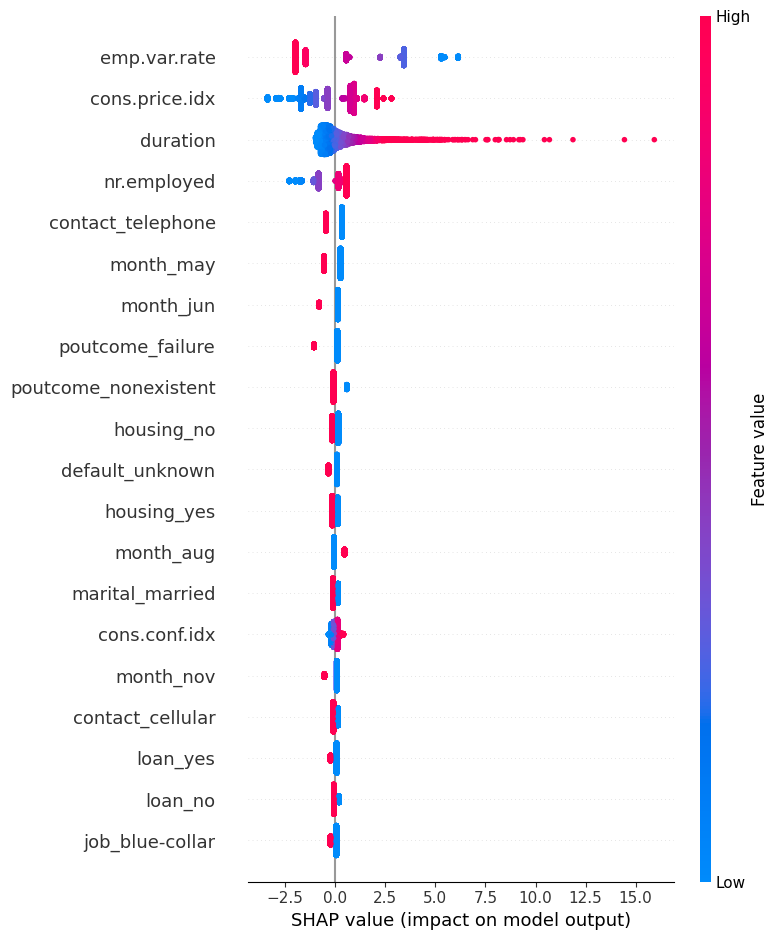

In [35]:
log_reg_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

log_reg_model = LogisticRegression(max_iter=100, random_state=2)

log_reg_grid_search = GridSearchCV(log_reg_model, log_reg_param_grid, cv=5, scoring='accuracy', verbose=1)
log_reg_grid_search.fit(X_train_scaled, y_train)

print("Logistic Regression - Best Parameters:", log_reg_grid_search.best_params_)
print("Logistic Regression - Best Cross-validation Score:", log_reg_grid_search.best_score_)

log_reg_best_model = log_reg_grid_search.best_estimator_
log_reg_y_pred = log_reg_best_model.predict(X_test_scaled)

log_reg_accuracy = accuracy_score(y_test, log_reg_y_pred)
print("\nLogistic Regression - Performance on Test Set:")
print(f"Accuracy: {log_reg_accuracy:.4f}")
print(classification_report(y_test, log_reg_y_pred))

explainer = shap.Explainer(log_reg_best_model, X_train_scaled)
shap_values = explainer(X_test_scaled)

shap.summary_plot(shap_values, X_test_scaled, feature_names=X_test_scaled.columns)

In [36]:
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_model = RandomForestClassifier(random_state=2)

rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=5, scoring='accuracy', verbose=1)
rf_grid_search.fit(X_train_scaled, y_train)

print("Random Forest - Best Parameters:", rf_grid_search.best_params_)
print("Random Forest - Best Cross-validation Score:", rf_grid_search.best_score_)

rf_best_model = rf_grid_search.best_estimator_
rf_y_pred = rf_best_model.predict(X_test_scaled)

rf_accuracy = accuracy_score(y_test, rf_y_pred)
print("\nRandom Forest - Performance on Test Set:")
print(f"Accuracy: {rf_accuracy:.4f}")
print(classification_report(y_test, rf_y_pred))

explainer = shap.Explainer(rf_best_model, X_train_scaled)
shap_values = explainer(X_test_scaled)

shap.summary_plot(shap_values, X_test_scaled, feature_names=X_test_scaled.columns)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Random Forest - Best Parameters: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Random Forest - Best Cross-validation Score: 0.913444613050076

Random Forest - Performance on Test Set:
Accuracy: 0.9138
              precision    recall  f1-score   support

          no       0.93      0.98      0.95      7310
         yes       0.69      0.43      0.53       928

    accuracy                           0.91      8238
   macro avg       0.81      0.70      0.74      8238
weighted avg       0.90      0.91      0.90      8238



100%|===================| 16469/16476 [10:54<00:00]        

ExplainerError: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was 0.715463, while the model output was 0.743721. If this difference is acceptable you can set check_additivity=False to disable this check.

In [38]:
nb_model = GaussianNB()

nb_cv_scores = cross_val_score(nb_model, X_train_scaled, y_train, cv=5, scoring='accuracy')

print("Naive Bayes - Cross-validation scores:", nb_cv_scores)
print("Naive Bayes - Mean cross-validation score:", nb_cv_scores.mean())

nb_model.fit(X_train_scaled, y_train)

nb_y_pred = nb_model.predict(X_test_scaled)

nb_accuracy = accuracy_score(y_test, nb_y_pred)
print("\nNaive Bayes - Performance on Test Set:")
print(f"Accuracy: {nb_accuracy:.4f}")
print(classification_report(y_test, nb_y_pred))


Naive Bayes - Cross-validation scores: [0.78072838 0.79135053 0.79514416 0.79984825 0.78603945]
Naive Bayes - Mean cross-validation score: 0.7906221547799697

Naive Bayes - Performance on Test Set:
Accuracy: 0.8086
              precision    recall  f1-score   support

          no       0.96      0.82      0.88      7310
         yes       0.34      0.74      0.47       928

    accuracy                           0.81      8238
   macro avg       0.65      0.78      0.68      8238
weighted avg       0.89      0.81      0.84      8238



## Findings 

__Logistic Regression and Random Forest__ performed quit good and pretty similiar with an acc around __91%__ whereas NB    is only around 81%.<br> <br>
When it comes to SHAP values (atleast for Logistic Regression) we can see clear tendenencies when looking at the top 3 variables:

__The Social and economic context__ attributes seem to be very important such as:<br> <br>
__emp.var.rate__ (employment variation rate)
   
* higher employment rate more likely that the client did not subscribe a term deposit<br>

__cons.price.indx__ (consumer price index)<br>

* higher conusmer price index more likely that the client did subscribe a term deposit 

Also important: __duration__ (last contact duration) <br>
* higher duration more likely that the clinet did subscribe a term deposit. <br>
* which makes sense since waiting for the right moment for the customuer is key.

